# NOTEBOOK FOR GENERATING FIGURE 3 

## RELIABILITY DIAGRAM OF ECMWF OVER PERIOD 1901-2010


* lower and upper tercile functions create .txt files for coords and uncertainty bands of reliability diagram

In [1]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from sklearn.linear_model import LinearRegression
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Bins used for the probabilities
bins=np.arange(0,1.1,0.1)
print(bins)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
def lower_tercile(ensemble, obs, x_yrs,time,s,full, label):

    PCs_data_full = ensemble
    PCs_full=PCs_data_full.reshape(51,full)
    #selecting relevant years of full dataset:
    PCs=PCs_full[:,x_yrs]
    PCs_data = PCs.reshape(51*time)
    PCs_data_copy = copy.copy(PCs_data)
    val= np.percentile(PCs_data, 33, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    tot=int(51*time)
    for m in range(tot):
        if PCs_data[m] < val :
            PCs_data_copy[m]=1
        else :
            PCs_data_copy[m]=0
            
    #matrix of 1's for tercile event and 0's
    binary_matrix=PCs_data_copy.reshape(51, time)

    #probabilities of warm winter for each year:
    #sum columns to give number of ensembles that say warm event for that year
    column_sums = binary_matrix.sum(axis=0)
    probabilities= column_sums/51

    prob= np.transpose(np.array([np.arange(time),probabilities,np.zeros(time)]))

    #sort by probabilities
    prob_sort= prob[prob[:, 1].argsort()]
    np. set_printoptions(suppress=True)
    prob_copy = copy.copy(prob_sort[:])
    bins=np.arange(0,1.1,0.1)
    #to catagorize probabilities into correct bins
    for n in range(1,11):
        for p in range(time):
            if bins[n-1]<=prob_sort[p,1]< bins[n] :
                prob_copy[p,2]=n
    #sort back in time order, so prob_copy_ordered=[time coord,probabilities, bin no.]
    prob_copy_ordered=prob_copy[prob_copy[:, 0].argsort()]
    
    #observed data:
    tas_cube_o_full = obs
    tas_cube_o = tas_cube_o_full[x_yrs]

    #sort observed data and set lower tercile(warm events) to 1
    obsv= np.transpose(np.array([np.arange(time),tas_cube_o, np.zeros(time)]))
    obsv_sort= obsv[obsv[:, 1].argsort()]
    obsv_sort[:,2]=np.arange(1,time+1)
    np. set_printoptions(suppress=True)
    val_o= np.percentile(tas_cube_o.data, 33 , axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for n in range(1,time+1):
            if obsv_sort[n-1,1] < val_o :
                obsv_sort[n-1,1]=1
            else :      obsv_sort[n-1,1]=0

    #obsv_re_sort is an array of years and corresponding 1's and 0's for cold winters over UK
    obsv_re_sort= obsv_sort[obsv_sort[:, 0].argsort()]

    obsv_bins=np.transpose(np.array([obsv_re_sort[:,0],obsv_re_sort[:,1],prob_copy_ordered[:,2],prob_copy_ordered[:,1]]))
    # obsv_bins=[time ordered, observed 1's and 0's, bin no., model probabilities]
    obsv_bins_sort= obsv_bins[obsv_bins[:, 2].argsort()]
    #obsv_bins_sort is array with corresponding bin of year from forecast data

    y_co=np.zeros(10)
    x_co=np.zeros(10)
    C=np.zeros(40).reshape((10,4))

    for n in range(1,11):
        A=np.zeros(time*4).reshape((time,4))
        for p in range(1,time+1):
            if n == obsv_bins_sort[p-1,2]:
                #A selects all data in one bin at a time
                A[p-1,:]=obsv_bins_sort[p-1,:]
        B=A.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
        D=B[2]/n #no. of years in bin
        F=B[3] # to avg x coord
        E=[n,B[1],D,0]
        C[n-1,:]=E
        y_co[n-1]= E[1]/E[2]
        x_co[n-1]=F/D

    coords=np.transpose(np.array([x_co, y_co, C[:,2], np.zeros(10)]))
    coords_new=coords[~np.isnan(coords).any(axis=1)] #removing bins with no coordinate

    size=coords_new[:,2] #size of each coord
    sh=coords_new[:,0].size #number of coords
    coords_new[:,3]=sh
    #save x and y coords
    a_file = open("NAO_"+s+label+"_coords_lower_tercile.txt", "w")
    for row in coords_new:
        np.savetxt(a_file, row)
    a_file.close()
    
    rego= np.zeros(1000)

    for i in range(1000):
        random_indices = np.random.choice(time, size=time, replace=True)
        rand_sample = obsv_bins_sort[random_indices,:]
        #sum columns to give number of ensembles that say warm event for that year
        y_co_unc=np.zeros(10)
        x_co_unc=np.zeros(10)
        C_unc=np.zeros(40).reshape((10,4))
        for n in range(1,11):
            A_unc=np.zeros(4*time).reshape((time,4))
            for p in range(1,time+1):
                if n == rand_sample[p-1,2]:
                    A_unc[p-1,:]=rand_sample[p-1,:]
            B_unc=A_unc.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin         
            D_unc=B_unc[2]/n #no. of years in bin
            F_unc=B_unc[3] #avg x coord
            E_unc=[n,B_unc[1],D_unc,0]
            C_unc[n-1,:]=E_unc
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                y_co_unc[n-1]= E_unc[1]/E_unc[2]
                x_co_unc[n-1]=F_unc/D_unc

        coords_unc=np.transpose(np.array([x_co_unc, y_co_unc, C_unc[:,2]]))
        coords_new_unc=coords_unc[~np.isnan(coords_unc).any(axis=1)]

        size_unc=coords_new_unc[:,2]
        sh_unc=coords_new_unc[:,0].size

        p_unc=coords_new_unc[:,0].reshape(-1,1)
        q_unc=coords_new_unc[:,1]
        model_unc= LinearRegression()
        model_unc.fit(p_unc,q_unc,size_unc[0:sh_unc])
        p_new_unc = coords_new_unc[:,0]
        q_new_unc = model_unc.predict(p_new_unc[:, np.newaxis])
        rego[i]=model_unc.coef_

    reg_sorto= rego[rego.argsort()]
    unc_reg_u= np.zeros(2)
    unc_reg_u[0]= np.percentile(reg_sorto, 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg_u[1]= np.percentile(reg_sorto, 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    #save uncertainty regions
    a_file = open("unc_reg_l"+s+label+".txt", "w")
    np.savetxt(a_file, unc_reg_u)
    a_file.close()
    

In [4]:
def upper_tercile(ensemble, obs, x_yrs,time,s, full, label):

    PCs_data_full = ensemble
    PCs_full=PCs_data_full.reshape(51, full)
    #selecting relevant years of full dataset:
    PCs=PCs_full[:,x_yrs]
    PCs_data = PCs.reshape(51*time)
    PCs_data_copy = copy.copy(PCs_data)
    val= np.percentile(PCs_data, 67, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    tot=int(51*time)
    for m in range(tot):
        if PCs_data[m] > val :
            PCs_data_copy[m]=1
        else :
            PCs_data_copy[m]=0
    #matrix of 1's for tercile event and 0's
    binary_matrix=PCs_data_copy.reshape(51, time)

    #probabilities of warm winter for each year:
    #sum columns to give number of ensembles that say warm event for that year
    column_sums = binary_matrix.sum(axis=0)
    probabilities= column_sums/51

    prob= np.transpose(np.array([np.arange(time),probabilities,np.zeros(time)]))
    #prob[:,1]= probabilities
    #prob[:,0]=np.arange(time)
    #sort by probabilities
    prob_sort= prob[prob[:, 1].argsort()]
    np. set_printoptions(suppress=True)
    prob_copy = copy.copy(prob_sort[:])
    bins=np.arange(0,1.1,0.1)
    #to catagorize probabilities into correct bins
    for n in range(1,11):
        for p in range(time):
            if bins[n-1]<=prob_sort[p,1]< bins[n] :
                prob_copy[p,2]=n
    #sort back in time order, so prob_copy_ordered=[time coord,probabilities, bin no.]
    prob_copy_ordered=prob_copy[prob_copy[:, 0].argsort()]
    
    #observed data:
    tas_cube_o_full = obs
    tas_cube_o = tas_cube_o_full[x_yrs]

    #sort observed data and set lower tercile(warm events) to 1
    obsv= np.transpose(np.array([np.arange(time),tas_cube_o, np.zeros(time)]))
    obsv_sort= obsv[obsv[:, 1].argsort()]
    obsv_sort[:,2]=np.arange(1,time+1)
    np. set_printoptions(suppress=True)
    val_o= np.percentile(tas_cube_o.data, 67 , axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for n in range(1,time+1):
            if obsv_sort[n-1,1] > val_o :
                obsv_sort[n-1,1]=1
            else :      obsv_sort[n-1,1]=0

    #obsv_re_sort is an array of years and corresponding 1's and 0's for cold winters over UK
    obsv_re_sort= obsv_sort[obsv_sort[:, 0].argsort()]

    obsv_bins=np.transpose(np.array([obsv_re_sort[:,0],obsv_re_sort[:,1],prob_copy_ordered[:,2],prob_copy_ordered[:,1]]))
    # obsv_bins=[time ordered, observed 1's and 0's, bin no., model probabilities]
    obsv_bins_sort= obsv_bins[obsv_bins[:, 2].argsort()]
    #obsv_bins_sort is array with corresponding bin of year from forecast data

    y_co=np.zeros(10)
    x_co=np.zeros(10)
    C=np.zeros(40).reshape((10,4))

    for n in range(1,11):
        A=np.zeros(time*4).reshape((time,4))
        for p in range(1,time+1):
            if n == obsv_bins_sort[p-1,2]:
                #A selects all data in one bin at a time
                A[p-1,:]=obsv_bins_sort[p-1,:]
        B=A.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
        D=B[2]/n #no. of years in bin
        F=B[3] # to avg x coord
        E=[n,B[1],D,0]
        C[n-1,:]=E
        y_co[n-1]= E[1]/E[2]
        x_co[n-1]=F/D

    coords=np.transpose(np.array([x_co, y_co, C[:,2], np.zeros(10)]))
    coords_new=coords[~np.isnan(coords).any(axis=1)] #removing bins with no coordinate

    size=coords_new[:,2] #size of each coord
    sh=coords_new[:,0].size #number of coords
    coords_new[:,3]=sh

    a_file = open("NAO_"+s+label+"_coords_upper_tercile.txt", "w")
    for row in coords_new:
        np.savetxt(a_file, row)
    a_file.close()
    
    rego= np.zeros(1000)

    for i in range(1000):
        random_indices = np.random.choice(time, size=time, replace=True)
        rand_sample = obsv_bins_sort[random_indices,:]
        #sum columns to give number of ensembles that say warm event for that year
        y_co_unc=np.zeros(10)
        x_co_unc=np.zeros(10)
        C_unc=np.zeros(40).reshape((10,4))
        for n in range(1,11):
            A_unc=np.zeros(4*time).reshape((time,4))
            for p in range(1,time+1):
                if n == rand_sample[p-1,2]:
                    A_unc[p-1,:]=rand_sample[p-1,:]
            B_unc=A_unc.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin         
            D_unc=B_unc[2]/n #no. of years in bin
            F_unc=B_unc[3] #avg x coord
            E_unc=[n,B_unc[1],D_unc,0]
            C_unc[n-1,:]=E_unc
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                y_co_unc[n-1]= E_unc[1]/E_unc[2]
                x_co_unc[n-1]=F_unc/D_unc

        coords_unc=np.transpose(np.array([x_co_unc, y_co_unc, C_unc[:,2]]))
        coords_new_unc=coords_unc[~np.isnan(coords_unc).any(axis=1)]

        size_unc=coords_new_unc[:,2]
        sh_unc=coords_new_unc[:,0].size

        p_unc=coords_new_unc[:,0].reshape(-1,1)
        q_unc=coords_new_unc[:,1]
        model_unc= LinearRegression()
        model_unc.fit(p_unc,q_unc,size_unc[0:sh_unc])
        p_new_unc = coords_new_unc[:,0]
        q_new_unc = model_unc.predict(p_new_unc[:, np.newaxis])
        rego[i]=model_unc.coef_

    reg_sorto= rego[rego.argsort()]
    unc_reg_u= np.zeros(2)
    unc_reg_u[0]= np.percentile(reg_sorto, 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg_u[1]= np.percentile(reg_sorto, 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    a_file = open("unc_reg_u"+s+label+".txt", "w")
    np.savetxt(a_file, unc_reg_u)
    a_file.close()
    

In [20]:
#time is number of years included, s is string of years for filenames 
#x_yrs is range of years selected from 0-109 corresponding to 1902-2010

s='1902-2010'
start_yr=1902
time= 2010-start_yr+1
full=109

x_yrs=np.arange(time)+start_yr-1902
total=time*51

In [12]:
#time is number of years included, s is string of years for filenames 
#x_yrs is range of years selected from 0-109 corresponding to 1902-2010

s='1980-2010'
start_yr=1980
time= 2010-start_yr+1
full=109

x_yrs=np.arange(time)+start_yr-1902
total=time*51

In [1]:
#DJF average
title='DJF average'

#unadjusted data and label
ensemble=np.loadtxt("timeseries_NAO_ECMWF_1901-2010.txt")
obs=np.loadtxt("timeseries_NAO_ERA20C_1901-2010.txt")
label_un='DJF_unadj'
lower_tercile(ensemble, obs, x_yrs,time,s,full, label_un)
upper_tercile(ensemble, obs, x_yrs,time,s,full, label_un)


NameError: name 'np' is not defined

In [22]:
#data for plots


t=np.full((50),0.3333333)
x=np.linspace(0,1,50)
y=np.linspace(0,1,50)
yt=np.linspace(-0.05,1.05,50)



#UPPER TERCILE

#coords
NAO_unadu = np.loadtxt("NAO_"+s+label_un+"_coords_upper_tercile.txt")
up=int(NAO_unadu.size/4)
NAO_unadju = NAO_unadu.reshape(up,4)
x_unadu = NAO_unadju[:,0]
y_unadu = NAO_unadju[:,1]
size_unadu= NAO_unadju[:,2]


#regression line
p_unu=x_unadu.reshape(-1,1)
q_unu=y_unadu
modelllu= LinearRegression()
modelllu.fit(p_unu,q_unu,size_unadu)
q_unnewu = modelllu.predict(p_unu)
q_regunu=modelllu.coef_
q_intunu=modelllu.intercept_

#uncertainities
uncert_regu_un=np.loadtxt("unc_reg_u"+s+label_un+".txt")
m1_unu=uncert_regu_un[0]
m2_unu=uncert_regu_un[1]
c1_unu=0.3333333-0.3333333*m1_unu
c2_unu=0.3333333-0.3333333*m2_unu



#LOWER TERCILE

#coords
NAO_unadl = np.loadtxt("NAO_"+s+label_un+"_coords_lower_tercile.txt")
low=int(NAO_unadl.size/4)
NAO_unadjl = NAO_unadl.reshape(low,4)
x_unadl = NAO_unadjl[:,0]
y_unadl = NAO_unadjl[:,1]
size_unadl= NAO_unadjl[:,2]


#regression
p_unl=x_unadl.reshape(-1,1)
q_unl=y_unadl
modellll= LinearRegression()
modellll.fit(p_unl,q_unl,size_unadl)
p_unnewl = p_unl
q_unnewl = modellll.predict(p_unnewl)
q_regunl=modellll.coef_
q_intunl=modellll.intercept_


#uncertainties
uncert_regl_un=np.loadtxt("unc_reg_l"+s+label_un+".txt")
m1_unl=uncert_regl_un[0]
m2_unl=uncert_regl_un[1]
c1_unl=0.3333333-0.3333333*m1_unl
c2_unl=0.3333333-0.3333333*m2_unl


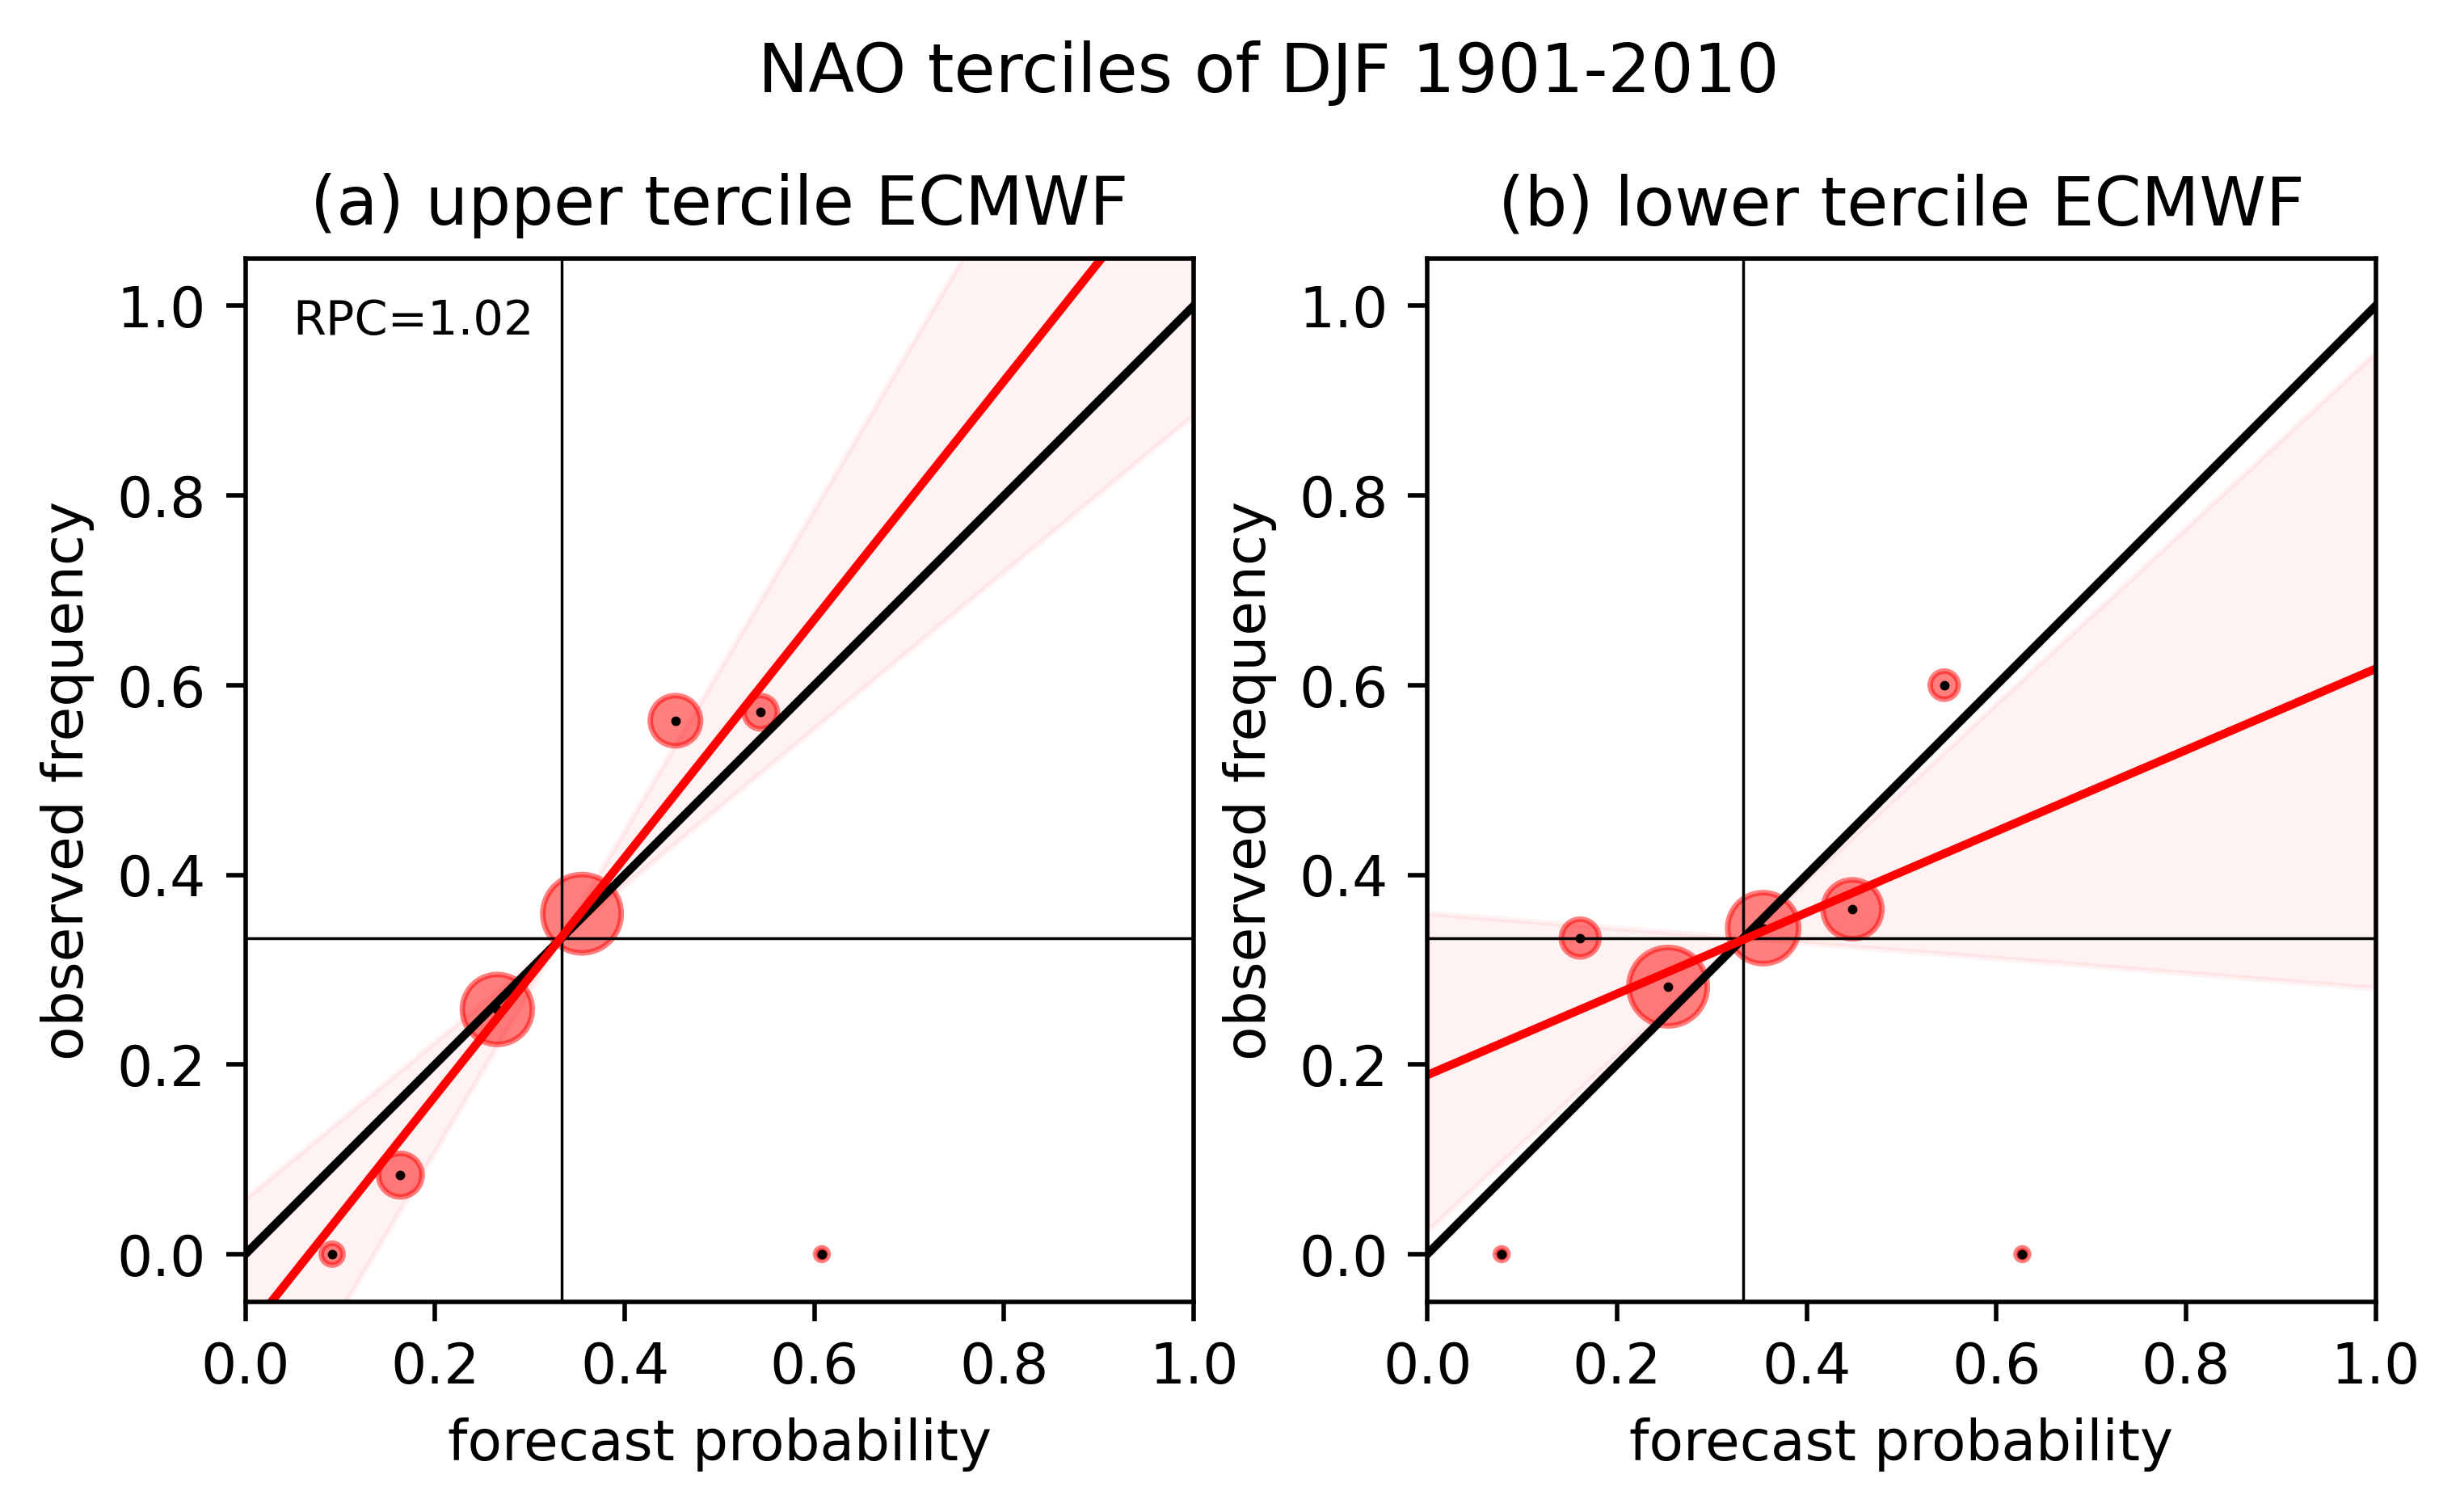

In [23]:
#create reliability plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1,2, figsize=(6,4), dpi=500)
fig.tight_layout()

fig.suptitle('NAO terciles of DJF 1901-2010')

for i in range(2):
    axs[i].set_aspect(1)
    axs[i].plot(x,t,c='black',linewidth=0.5)
    axs[i].plot(t,yt,c='black', linewidth=0.5)
    axs[i].plot(x,y,c='black')
    axs[i].set_xlim([0,1])
    axs[i].set_ylim([-0.05, 1.05])
    axs[i].set_xlabel('forecast probability')
    axs[i].set_ylabel('observed frequency')
    
axs[0].set_title('(a) upper tercile ECMWF')
axs[1].set_title('(b) lower tercile ECMWF')

#upper unadjusted
axs[0].scatter(x_unadu, y_unadu, c='r', alpha=0.5, s=size_unadu*5)
axs[0].scatter(x_unadu, y_unadu, c='black', s=0.5)
axs[0].plot(x,q_regunu*x + q_intunu, c='red')
axs[0].fill_between(x, m1_unu*x+c1_unu, m2_unu*x+c2_unu,alpha=0.05,color='red')
axs[0].annotate('RPC=1.02',(0.05,0.97), fontsize=8.5) #RPC computed separately elsewhere


#lower unadjusted
axs[1].scatter(x_unadl, y_unadl, c='r',alpha=0.5, s=size_unadl*5)
axs[1].scatter(x_unadl, y_unadl, c='black', s=0.5)
axs[1].plot(x,q_regunl*x + q_intunl, c='red')
axs[1].fill_between(x, m1_unl*x+c1_unl, m2_unl*x+c2_unl,alpha=0.05,color='red')


plt.show()